Importando bibliotecas

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [45]:
df = pd.read_csv("D:\\github\\SIGAMA-data-analysis\\data\\dataset_normalizado_anonimizado.csv")
train_df = pd.read_csv("D:\\github\\SIGAMA-data-analysis\\data\\train_dataset.csv")
test_df = pd.read_csv("D:\\github\\SIGAMA-data-analysis\\data\\test_dataset.csv")

Logistic Regression

In [46]:
features = ["tipo_pf", "dia", "mes_num", "attempt_number", "previous_rejections"]

X_train = train_df[features]
y_train = train_df["approved"]

X_test = test_df[features]
y_test = test_df["approved"]

In [47]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [48]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.09      0.16       214
           1       0.62      0.96      0.76       334

    accuracy                           0.62       548
   macro avg       0.62      0.53      0.46       548
weighted avg       0.62      0.62      0.52       548



In [49]:
from sklearn.metrics import roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)

ROC-AUC: 0.5919189658067043


In [50]:
model = LogisticRegression(max_iter=1000, class_weight="balanced")

Chi-Square Test

In [51]:
df.columns = df.columns.str.strip().str.lower()

# Criar variável binária de aprovação
df["approved"] = (df["status"] == "APROVADO").astype(int)

In [52]:
contingency = pd.crosstab(df["tipo_de_conta"], df["approved"])

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 9.123288150594922
p-value: 0.0025237593125928787


Spearman Correlation

In [53]:
df = df.sort_values(["cpf_hash", "ano", "mês", "dia"])

df["attempt_number"] = df.groupby("cpf_hash").cumcount() + 1

df.head()

,status,tipo_de_conta,ano,mês,dia,cpf_hash,approved,attempt_number
1420,REPROVADO,Pessoa Física,2025,Dezembro,19,00225a26400ca5b3947a50f9484809f0935b28d319371e...,0,1
422,APROVADO,Pessoa Física,2025,Novembro,11,003b6930bfaeeedb089bd7c0cee082b7f18de35d448ffb...,1,1
1359,APROVADO,Pessoa Física,2025,Dezembro,10,004a67a521ac8b9c58ed216bd940fddc674cd2782f055f...,1,1
1496,REPROVADO,Pessoa Física,2025,Agosto,12,006794d3a86baa884268a3f5fa6375685dd85c7e375555...,0,1
329,APROVADO,Pessoa Física,2025,Outubro,15,006794d3a86baa884268a3f5fa6375685dd85c7e375555...,1,2


In [54]:
corr_day, p_day = spearmanr(df["dia"], df["approved"])
corr_attempt, p_attempt = spearmanr(df["attempt_number"], df["approved"])

print("Spearman Day vs Approval:", corr_day, p_day)
print("Spearman Attempt vs Approval:", corr_attempt, p_attempt)

Spearman Day vs Approval: 0.013453087783753146 0.564880457304036
Spearman Attempt vs Approval: -0.0679804273371657 0.0035927574888419593


Survival Analysis

In [55]:
df = df.sort_values(["cpf_hash", "ano", "mês", "dia"])
df["attempt_number"] = df.groupby("cpf_hash").cumcount() + 1

In [56]:
survival_df = (
    df.groupby("cpf_hash")
      .agg(
          duration=("attempt_number", "max"),
          event=("approved", "max")  # 1 se foi aprovado alguma vez
      )
      .reset_index()
)

survival_df.head()

,cpf_hash,duration,event
0,00225a26400ca5b3947a50f9484809f0935b28d319371e...,1,0
1,003b6930bfaeeedb089bd7c0cee082b7f18de35d448ffb...,1,1
2,004a67a521ac8b9c58ed216bd940fddc674cd2782f055f...,1,1
3,006794d3a86baa884268a3f5fa6375685dd85c7e375555...,2,1
4,007404c23818cd432012913a158d8c258ffd4a7b1a10cf...,3,1


Kaplan-Meier

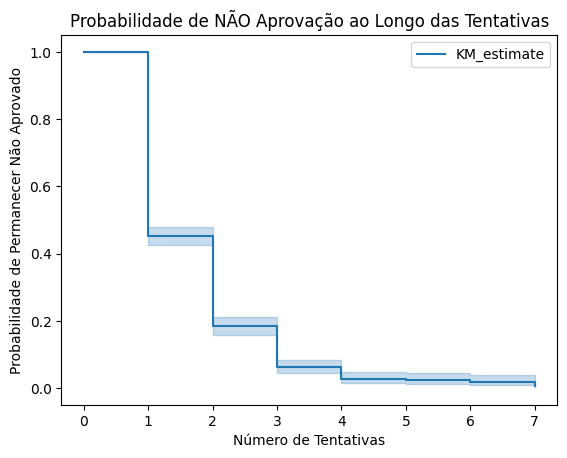

In [57]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

kmf.fit(
    durations=survival_df["duration"],
    event_observed=survival_df["event"]
)

kmf.plot_survival_function()
plt.title("Probabilidade de NÃO Aprovação ao Longo das Tentativas")
plt.xlabel("Número de Tentativas")
plt.ylabel("Probabilidade de Permanecer Não Aprovado")
plt.show()

In [58]:
1 - kmf.survival_function_

,KM_estimate
timeline,
0.0,0.000000
1.0,0.547002
2.0,0.816009
3.0,0.937322
4.0,0.972143
5.0,0.976123
6.0,0.980898
7.0,0.995225
